In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import sys, os
sys.path.append('../../src/')

import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

import bmk_beeline as bmk
import genie3, g_admm
import kernel
import time
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [2]:
import subprocess as sp
import os

def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

In [3]:
!nvidia-smi

Wed Oct  6 16:11:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Tesla V1...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   34C    P0    24W / 250W |      4MiB / 16160MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
get_gpu_memory()

[16156]

In [5]:
import numpy as np
import torch
from torch_sqrtm import MatrixSquareRoot

from torch.optim import Adam

torch_sqrtm = MatrixSquareRoot.apply

class G_admm_minibatch():
    def __init__(self, X, K, TF = None, seed = 0, pre_cov = None, batchsize = None):
        super(G_admm_minibatch, self).__init__()
        # set random seed
        if seed is not None:
            torch.manual_seed(seed)

        # shape (ntimes, nsamples, ngenes)
        self.X = torch.FloatTensor(X)
        self.ntimes, self.nsamples, self.ngenes = self.X.shape
        
        # calculate batchsize
        if batchsize is None:
            self.batchsize = int(self.ntimes/10)
        else:
            self.batchsize = batchsize
        # calculate empirical covariance matrix
        if pre_cov is None:
            # shape (ntimes, nsamples, ngenes)
            self.epir_mean = self.X.mean(dim = 1, keepdim = True)
            X = self.X - self.epir_mean
            # (ntimes * nsamples, ngenes, ngenes)
            self.empir_cov = torch.bmm(X.reshape((self.ntimes * self.nsamples, self.ngenes, 1)), X.reshape((self.ntimes * self.nsamples, 1, self.ngenes)))
            # (ntimes, ngenes, ngenes)
            self.empir_cov = torch.sum(self.empir_cov.reshape((self.ntimes, self.nsamples, self.ngenes, self.ngenes)), dim = 1)/(self.nsamples - 1)
        else:
            self.empir_cov = pre_cov

        # weight kernel function, shape (ntimes, ntimes)
        self.weights = torch.FloatTensor(K)
        # weighted average of empricial covariance matrix
        assert torch.all(torch.sum(self.weights,dim=1) - 1 < 1e-6)
        self.w_empir_cov = torch.sum((self.weights[:,:,None,None]*self.empir_cov[None,:,:,:]),dim=1) 
        # store the result
        self.thetas = np.zeros((self.ntimes, self.ngenes, self.ngenes))
        
        # mask matrix (ntimes, ngenes, ngenes)
        if TF is not None:
            self.mask = torch.zeros(self.ngenes, self.ngenes)
            # mark probable interactions
            self.mask[TF, :] = 1
            self.mask[:, TF] = 1
            # element-wise reverse
            self.mask = 1 - self.mask
            self.mask = self.mask.expand(self.ntimes, self.ngenes, self.ngenes) 
        else:
            self.mask = torch.FloatTensor([0])  

    @staticmethod
    def neg_lkl_loss(thetas, S):
        """\
        Description:
        --------------
            The negative log likelihood function
        Parameters:
        --------------
            theta:
                The estimated theta
            S:
                The empirical covariance matrix
        Return:
        --------------
            The negative log likelihood value
        """
        # logdet works for batches of matrices, give a high dimensional data
        t1 = -1*torch.logdet(thetas)
        t2 = torch.stack([torch.trace(mat) for mat in torch.bmm(S, thetas)])
        return t1 + t2


    def train(self, max_iters = 50, n_intervals = 1, lamb = 2.1e-4, alpha = 1, rho = 1, beta = 0, theta_init_offset = 0.1):
        n_batches = int(np.ceil(self.ntimes/self.batchsize))
        for batch in range(n_batches):
            # select a minibatch, and load to cuda
            start_idx = batch * self.batchsize
            if batch < n_batches - 1:
                end_idx = (batch + 1) * self.batchsize
                w_empir_cov = self.w_empir_cov[start_idx:end_idx, :, :].to(device)
                if self.mask.shape[0] == self.ntimes:
                    mask = self.mask[start_idx:end_idx, :, :].to(device)
                else:
                    mask = self.mask.to(device)
            else:
                w_empir_cov = self.w_empir_cov[start_idx:, :, :].to(device)
                if self.mask.shape[0] == self.ntimes:
                    mask = self.mask[start_idx:, :, :].to(device)
                else:
                    mask = self.mask.to(device)
            # initialize mini-batch, Z of the shape (batch_size, ngenes, ngenes)
            Z = torch.diag_embed(1/(torch.diagonal(w_empir_cov, offset=0, dim1=-2, dim2=-1) + theta_init_offset))
            # make Z positive definite matrix
            ll = torch.cholesky(Z)
            Z = torch.matmul(ll, ll.transpose(-1, -2))
            U = torch.zeros(Z.shape).to(device)
            I = torch.eye(self.ngenes).expand(Z.shape).to(device)

            it = 0
            # hyper-parameter for batches
            if rho is None:
                updating_rho = True
                # rho of the shape (ntimes, 1, 1)
                b_rho = torch.ones((Z.shape[0], 1, 1)).to(device) * 1.7
            else:
                b_rho = torch.FloatTensor([rho] * Z.shape[0])[:, None, None].to(device)
                updating_rho = False
            b_alpha = alpha 
            b_beta = beta
            b_lamb = lamb
            while(it < max_iters): 
                # Primal 
                Y = U - Z + w_empir_cov/b_rho    # (ntimes, ngenes, ngenes)
                thetas = - 0.5 * Y + torch.stack([torch_sqrtm(mat) for mat in (torch.transpose(Y,1,2) @ Y * 0.25 + I/b_rho)])
                Z_pre = Z.detach().clone()
                # over-relaxation
                thetas = b_alpha * thetas + (1 - b_alpha) * Z_pre            
                Z = torch.sign(thetas + U) * torch.max((b_rho * (thetas + U).abs() - b_lamb)/(b_rho + b_beta * mask), torch.Tensor([0]).to(device))

                # Dual
                U = U + thetas - Z

                # calculate residual
                # primal_residual and dual_residual of the shape (ntimes, 1, 1)
                primal_residual = torch.sqrt((thetas - Z).pow(2).sum(1).sum(1))
                dual_residual = b_rho.squeeze() * torch.sqrt((Z - Z_pre).pow(2).sum(1).sum(1))

                # updating rho, rho should be of shape (ntimes, 1, 1)
                if updating_rho:
                    mask_inc = (primal_residual > 10 * dual_residual)
                    b_rho[mask_inc, :, :] = b_rho[mask_inc, :, :] * 2
                    mask_dec = (dual_residual > 10 * primal_residual)
                    b_rho[mask_dec, :, :] = b_rho[mask_dec, :, :] / 2
                
                # print(rho.squeeze())
                # free-up memory
                del Z_pre
                
                # Stopping criteria
                if (it + 1) % n_intervals == 0:
                    print("Current GPU memory: ") 
                    print(get_gpu_memory())
                    # calculate sum of all duality gap
                    # loss = self.neg_lkl_loss(thetas, w_empir_cov).sum() + b_lamb * Z.abs().sum() + b_beta * (self.mask * Z).pow(2).sum()
                    # primal_val = loss  + rho/2 * (thetas - Z).pow(2).sum()
                    # dual_val = loss + rho/2 * (thetas - Z + U).pow(2).sum() - rho/2 * U.pow(2).sum()
                    # duality_gap = primal_val - dual_val

                    # simplify min of all duality gap
                    duality_gap = b_rho.squeeze() * torch.stack([torch.trace(mat) for mat in torch.bmm(U.permute(0,2,1), Z - thetas)])
                    duality_gap = duality_gap.abs()
                    print("n_iter: {}, duality gap: {:.4e}, primal residual: {:.4e}, dual residual: {:4e}".format(it+1, duality_gap.max().item(), primal_residual.max().item(), dual_residual.max().item()))
                    
                    # if duality_gap < 1e-8:
                    #     break
                    primal_eps = 1e-6
                    dual_eps = 1e-6
                    if (primal_residual.max() < primal_eps) and (dual_residual.max() < dual_eps):
                        break                
                it += 1
            
            loss1 = self.neg_lkl_loss(Z, w_empir_cov).sum()
            loss2 = Z.abs().sum()
            loss3 = (mask * Z).pow(2).sum()
            print("Batche loss: loss1: {:.5f}, loss2: {:.5f}, loss3: {:.5f}".format(loss1.item(), loss2.item(), loss3.item()))  
            # store values
            if batch < n_batches - 1:
                self.thetas[start_idx:end_idx] = Z.detach().cpu().numpy()
            else:
                self.thetas[start_idx:] = Z.detach().cpu().numpy()
            del thetas, U, I, Y, ll, Z


        return self.thetas


def preprocess(counts): 
    """\
    Input:
    counts = (ntimes, ngenes)
    
    Description:
    ------------
    Preprocess the dataset
    """
    # normalize according to the library size
    
    libsize = np.median(np.sum(counts, axis = 1))
    counts = counts / np.sum(counts, axis = 1)[:,None] * libsize
        
    counts = np.log1p(counts)
    return counts

In [21]:
import importlib 
importlib.reload(g_admm)
importlib.reload(kernel)

<module 'kernel' from '../../src/kernel.py'>

In [14]:
ntimes = 1000
path = "../../data/GGM_changing_mean/"
for interval in [50, 100, 200]:
    for (ngenes, ntfs) in [(30, 5)]:
        result_dir = "../results/GGM_changing_mean_" + str(ntimes) + "_" + str(interval) + "_" + str(ngenes) + "/"
        if not os.path.exists(result_dir):
            os.makedirs(result_dir)
        # the data smapled from GGM is zero-mean
        X = np.load(path + "ntimes_" + str(ntimes) + "_interval_" + str(interval) + "_ngenes_" + str(ngenes) + "/expr.npy")
        print("Raw TimePoints: {}, no.Genes: {}".format(X.shape[0],X.shape[1]))
        # X = StandardScaler().fit_transform(X)

        # make sure the dimensions are correct
        assert X.shape[0] == ntimes
        assert X.shape[1] == ngenes

        sample = torch.FloatTensor(X).to(device)
        max_iters = 20
        ###############################################
        #
        # test without TF information
        #
        ###############################################

        for bandwidth in [0.1]:
            start_time = time.time()
            empir_cov = torch.zeros(ntimes, ngenes, ngenes)
            # calculate the kernel function
            K, K_trun = kernel.calc_kernel(X, k = 5, bandwidth = bandwidth, truncate = True)
            
            # building weighted covariance matrix, output is empir_cov of the shape (ntimes, ngenes, ngenes)
            for t in range(ntimes):
                weight = torch.FloatTensor(K_trun[t, :]).to(device)
                # assert torch.sum(weight) == 1

                bin_weight = torch.FloatTensor((K_trun[t, :] > 0).astype(np.int))
                sample_mean = torch.sum(sample * weight[:, None], dim = 0)
                # sample_mean = torch.sum(sample * (bin_weight/torch.sum(bin_weight))[:, None], dim = 0)

                norm_sample = sample - sample_mean[None, :]
                empir_cov[t] = torch.sum(torch.bmm(norm_sample[:,:,None], norm_sample[:,None,:]) * weight[:,None, None], dim=0)
            print("time calculating the kernel function: {:.2f} sec".format(time.time() - start_time))
            
            start_time = time.time()                    
            # run the model
            for lamb in [0.01]:
                # test model without TF
                thetas = np.zeros((ntimes,ngenes,ngenes))

                # setting from the paper over-relaxation model
                alpha = 2
                rho = 1.7
                gadmm_batch = g_admm.G_admm_batch(X=X[:, None, :], K=K, pre_cov=empir_cov)
                # gadmm_batch = G_admm_minibatch(X=X[:, None, :], K=K, pre_cov=empir_cov, batchsize = 1000)
                thetas = gadmm_batch.train(max_iters=max_iters, n_intervals=10, alpha=alpha, lamb=lamb, rho=rho, theta_init_offset=0.1)
                np.save(file = result_dir + "thetas_" + str(bandwidth) + "_" + str(alpha) + "_" + str(lamb) + "_" + str(rho) + ".npy", arr = thetas) 
                print("time calculating thetas: {:.2f} sec".format(time.time() - start_time))
            del thetas
            gadmm_batch = None
            gc.collect()


Raw TimePoints: 1000, no.Genes: 20
number of nearest neighbor: 6
number of nearest neighbor: 7
final number of nearest neighbor (make connected): 7
time calculating the kernel function: 3.18 sec


KeyboardInterrupt: 

Raw TimePoints: 1000, no.Genes: 20
test without TF information
number of nearest neighbor: 6
number of nearest neighbor: 7
final number of nearest neighbor (make connected): 7
time calculating the kernel function: 3.69 sec
n_iter: 100, duality gap: 1.5150e-05, primal residual: 1.2197e-03, dual residual: 1.630644e-01
n_iter: 200, duality gap: 9.3371e-06, primal residual: 6.8934e-04, dual residual: 1.306090e-01
n_iter: 300, duality gap: 7.1960e-06, primal residual: 4.9921e-04, dual residual: 1.086170e-01
n_iter: 400, duality gap: 5.4585e-06, primal residual: 3.8609e-04, dual residual: 9.634646e-02
n_iter: 500, duality gap: 4.2434e-06, primal residual: 3.1611e-04, dual residual: 8.762145e-02
n_iter: 600, duality gap: 3.3450e-06, primal residual: 2.8188e-04, dual residual: 8.060444e-02
n_iter: 700, duality gap: 2.9418e-06, primal residual: 2.4579e-04, dual residual: 7.465711e-02


KeyboardInterrupt: 

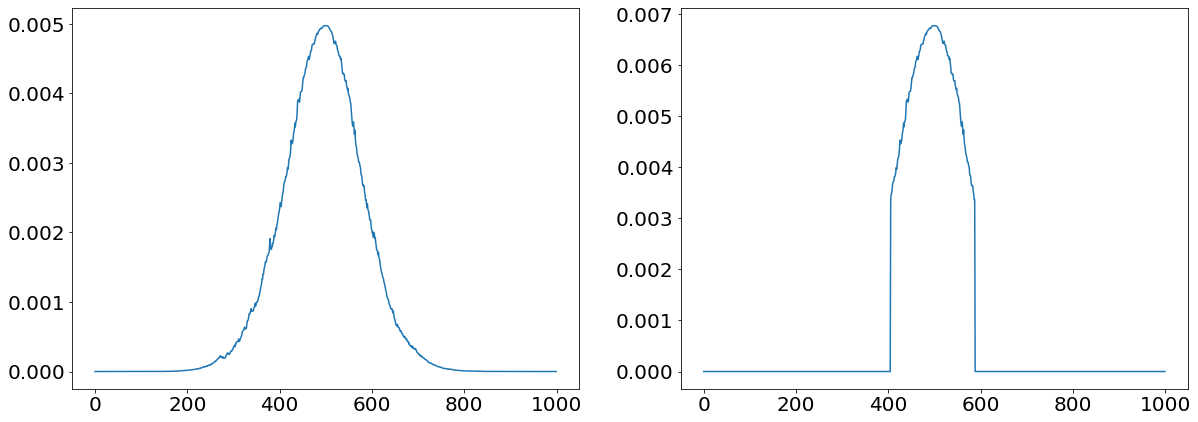

In [24]:
# In[0]
import pandas as pd
import numpy as np
import torch
import torch.nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import sys, os
sys.path.append('../../src/')

from scipy.spatial.distance import pdist, squareform

import bmk_beeline as bmk
import genie3, g_admm
import kernel
import time
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plt.rcParams["font.size"] = 20

def preprocess(counts): 
    """\
    Input:
    counts = (ntimes, ngenes)
    
    Description:
    ------------
    Preprocess the dataset
    """
    # normalize according to the library size
    
    libsize = np.median(np.sum(counts, axis = 1))
    counts = counts / np.sum(counts, axis = 1)[:,None] * libsize
        
    counts = np.log1p(counts)
    return counts

# In[1] test with the first set of hyper-parameters
ntimes = 1000
path = "../../data/GGM_changing_mean/"
max_iters = 2000
truncate_param = 7
for interval in [50]:
    for (ngenes, ntfs) in [(20, 5), (30, 10), (50, 20), (100, 50)]:
        result_dir = "../results/GGM_changing_mean_" + str(ntimes) + "_" + str(interval) + "_" + str(ngenes) + "/"
        if not os.path.exists(result_dir):
            os.makedirs(result_dir)
        # the data smapled from GGM is zero-mean
        X = np.load(path + "ntimes_" + str(ntimes) + "_interval_" + str(interval) + "_ngenes_" + str(ngenes) + "/expr.npy")
        # gt_adj = np.load(path + "ntimes_" + str(ntimes) + "_interval_" + str(interval) + "_ngenes_" + str(ngenes) + "/Gs.npy")

        # sort the genes
        print("Raw TimePoints: {}, no.Genes: {}".format(X.shape[0],X.shape[1]))
        # X = StandardScaler().fit_transform(X)

        # make sure the dimensions are correct
        assert X.shape[0] == ntimes
        assert X.shape[1] == ngenes

        sample = torch.FloatTensor(X).to(device)
        ###############################################
        #
        # test with the first set of hyper-parameters, without TF information
        #
        ###############################################
        print("test without TF information")
        for bandwidth in [0.1]:
            start_time = time.time()
            empir_cov = torch.zeros(ntimes, ngenes, ngenes)
            # calculate the kernel function
            K, K_trun = kernel.calc_kernel(X, k = 5, bandwidth = bandwidth, truncate = True, truncate_param = truncate_param)

            # plot kernel function
            fig = plt.figure(figsize = (20, 7))
            axs = fig.subplots(1, 2)
            axs[0].plot(K[int(ntimes/2), :])
            axs[1].plot(K_trun[int(ntimes/2), :])
            fig.savefig(result_dir + "kernel_" + str(bandwidth) + ".png", bbox_inches = "tight")

            # building weighted covariance matrix, output is empir_cov of the shape (ntimes, ngenes, ngenes)
            for t in range(ntimes):
                weight = torch.FloatTensor(K_trun[t, :]).to(device)
                # assert torch.sum(weight) == 1

                bin_weight = torch.FloatTensor((K_trun[t, :] > 0).astype(np.int))
                sample_mean = torch.sum(sample * weight[:, None], dim = 0)
                # sample_mean = torch.sum(sample * (bin_weight/torch.sum(bin_weight))[:, None], dim = 0)

                norm_sample = sample - sample_mean[None, :]
                empir_cov[t] = torch.sum(torch.bmm(norm_sample[:,:,None], norm_sample[:,None,:]) * weight[:,None, None], dim=0)
            print("time calculating the kernel function: {:.2f} sec".format(time.time() - start_time))
            
            start_time = time.time()                    
            # run the model
            for lamb in [0.01]:
                # test model without TF
                thetas = np.zeros((ntimes,ngenes,ngenes))

                # setting from the paper over-relaxation model
                alpha = 2
                rho = 1.7
                # gadmm_batch = g_admm.G_admm_batch(X=X[:, None, :], K=K, pre_cov=empir_cov)
                gadmm_batch = g_admm.G_admm_minibatch(X=X[:, None, :], K=K, pre_cov=empir_cov, batchsize = 100)
                thetas = gadmm_batch.train(max_iters=max_iters, n_intervals=100, alpha=alpha, lamb=lamb, rho=rho, theta_init_offset=0.1)
                np.save(file = result_dir + "thetas_" + str(bandwidth) + "_" + str(alpha) + "_" + str(lamb) + "_" + str(rho) + ".npy", arr = thetas) 
                print("time calculating thetas: {:.2f} sec".format(time.time() - start_time))
            del thetas
            gadmm_batch = None
            gc.collect()

        ###############################################
        #
        # test with TF information
        #
        ###############################################
        print("test with TF information")
        for bandwidth in [0.1]:
            start_time = time.time()
            empir_cov = torch.zeros(ntimes, ngenes, ngenes)
            K, K_trun = kernel.calc_kernel(X, k = 5, bandwidth = bandwidth, truncate = True, truncate_param = truncate_param)

            # building weighted covariance matrix, output is empir_cov of the shape (ntimes, ngenes, ngenes)
            for t in range(ntimes):
                weight = torch.FloatTensor(K_trun[t, :]).to(device)
                # assert torch.sum(weight) == 1

                bin_weight = torch.FloatTensor((K_trun[t, :] > 0).astype(np.int))
                sample_mean = torch.sum(sample * weight[:, None], dim = 0)
                # sample_mean = torch.sum(sample * (bin_weight/torch.sum(bin_weight))[:, None], dim = 0)

                norm_sample = sample - sample_mean[None, :]
                empir_cov[t] = torch.sum(torch.bmm(norm_sample[:,:,None], norm_sample[:,None,:]) * weight[:,None, None], dim=0)
            print("time calculating the kernel function: {:.2f} sec".format(time.time() - start_time))
            
            start_time = time.time()                                  
            # run the model
            for lamb in [0.01]:
                # test model without TF
                thetas = np.zeros((ntimes,ngenes,ngenes))

                # setting from the paper over-relaxation model
                alpha = 2
                rho = 1.7
                # gadmm_batch = g_admm.G_admm_batch(X=X[:, None, :], K=K, pre_cov=empir_cov, TF=np.arange(ntfs))
                gadmm_batch = g_admm.G_admm_minibatch(X=X[:, None, :], K=K, pre_cov=empir_cov, batchsize = 100, TF=np.arange(ntfs))
                thetas = gadmm_batch.train(max_iters=max_iters, n_intervals=100, alpha=alpha, lamb=lamb, rho=rho, beta=100, theta_init_offset=0.1)
                np.save(file = result_dir + "thetas_" + str(bandwidth) + "_" + str(alpha) + "_" + str(lamb) + "_" + str(rho) + "_tfs.npy", arr = thetas) 
                print("time calculating thetas: {:.2f} sec".format(time.time() - start_time))
            del thetas
            gadmm_batch = None
            gc.collect()


        ###############################################
        #
        # test with the second set of hyper-parameters, without TF information
        #
        ###############################################
        print("test without TF information")
        for bandwidth in [0.1]:
            start_time = time.time()
            empir_cov = torch.zeros(ntimes, ngenes, ngenes)
            # calculate the kernel function
            K, K_trun = kernel.calc_kernel(X, k = 5, bandwidth = bandwidth, truncate = True, truncate_param = truncate_param)

            # building weighted covariance matrix, output is empir_cov of the shape (ntimes, ngenes, ngenes)
            for t in range(ntimes):
                weight = torch.FloatTensor(K_trun[t, :]).to(device)
                # assert torch.sum(weight) == 1

                bin_weight = torch.FloatTensor((K_trun[t, :] > 0).astype(np.int))
                sample_mean = torch.sum(sample * weight[:, None], dim = 0)
                # sample_mean = torch.sum(sample * (bin_weight/torch.sum(bin_weight))[:, None], dim = 0)

                norm_sample = sample - sample_mean[None, :]
                empir_cov[t] = torch.sum(torch.bmm(norm_sample[:,:,None], norm_sample[:,None,:]) * weight[:,None, None], dim=0)
            print("time calculating the kernel function: {:.2f} sec".format(time.time() - start_time))
            
            start_time = time.time()                    
            # run the model
            for lamb in [0.01]:
                # test model without TF
                thetas = np.zeros((ntimes,ngenes,ngenes))

                # setting from the paper over-relaxation model
                alpha = 1
                rho = None
                # gadmm_batch = g_admm.G_admm_batch(X=X[:, None, :], K=K, pre_cov=empir_cov)
                gadmm_batch = g_admm.G_admm_minibatch(X=X[:, None, :], K=K, pre_cov=empir_cov, batchsize = 100)
                thetas = gadmm_batch.train(max_iters=max_iters, n_intervals=100, alpha=alpha, lamb=lamb, rho=rho, theta_init_offset=0.1)
                np.save(file = result_dir + "thetas_" + str(bandwidth) + "_" + str(alpha) + "_" + str(lamb) + "_" + str(rho) + ".npy", arr = thetas) 
                print("time calculating thetas: {:.2f} sec".format(time.time() - start_time))
            del thetas
            gadmm_batch = None
            gc.collect()

        ###############################################
        #
        # test with TF information
        #
        ###############################################
        print("test with TF information")
        for bandwidth in [0.1]:
            start_time = time.time()
            empir_cov = torch.zeros(ntimes, ngenes, ngenes)
            K, K_trun = kernel.calc_kernel(X, k = 5, bandwidth = bandwidth, truncate = True, truncate_param = truncate_param)

            # building weighted covariance matrix, output is empir_cov of the shape (ntimes, ngenes, ngenes)
            for t in range(ntimes):
                weight = torch.FloatTensor(K_trun[t, :]).to(device)
                # assert torch.sum(weight) == 1

                bin_weight = torch.FloatTensor((K_trun[t, :] > 0).astype(np.int))
                sample_mean = torch.sum(sample * weight[:, None], dim = 0)
                # sample_mean = torch.sum(sample * (bin_weight/torch.sum(bin_weight))[:, None], dim = 0)

                norm_sample = sample - sample_mean[None, :]
                empir_cov[t] = torch.sum(torch.bmm(norm_sample[:,:,None], norm_sample[:,None,:]) * weight[:,None, None], dim=0)
            print("time calculating the kernel function: {:.2f} sec".format(time.time() - start_time))
            
            start_time = time.time()                                  
            # run the model
            for lamb in [0.01]:
                # test model without TF
                thetas = np.zeros((ntimes,ngenes,ngenes))

                # setting from the paper over-relaxation model
                alpha = 1
                rho = None
                # gadmm_batch = g_admm.G_admm_batch(X=X[:, None, :], K=K, pre_cov=empir_cov, TF=np.arange(ntfs))
                gadmm_batch = g_admm.G_admm_minibatch(X=X[:, None, :], K=K, pre_cov=empir_cov, batchsize = 100, TF=np.arange(ntfs))
                thetas = gadmm_batch.train(max_iters=max_iters, n_intervals=100, alpha=alpha, lamb=lamb, rho=rho, beta=100, theta_init_offset=0.1)
                np.save(file = result_dir + "thetas_" + str(bandwidth) + "_" + str(alpha) + "_" + str(lamb) + "_" + str(rho) + "_tfs.npy", arr = thetas) 
                print("time calculating thetas: {:.2f} sec".format(time.time() - start_time))
            del thetas
            gadmm_batch = None
            gc.collect()
# %%
